In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import csv  
import time
import os, datetime
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.8.0


## Hyperparameters

In [2]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load Microsoft data

In [3]:
# df = pdr.get_data_tiingo("MSFT", api_key="aeeaa9dbc8f82f2c361abaa259050d75e736b424")

ticker = yf.Ticker("MSFT")
df = ticker.history(period="max")


df.to_csv("MSFT.csv")
df = pd.read_csv("MSFT.csv", delimiter=',', usecols=['Date', 'Close'])
df.sort_values('Date', inplace=True)
price_history = df
df = df["Close"]

prices = price_history[["Close"]].pct_change().dropna()

df

0         0.061252
1         0.063439
2         0.064533
3         0.062892
4         0.061799
           ...    
9098    280.519989
9099    285.299988
9100    286.359985
9101    280.809998
9102    274.029999
Name: Close, Length: 9103, dtype: float64

In [4]:
prices

,Close
1,0.035711
2,0.017251
3,-0.025431
4,-0.017390
5,-0.026547
...,...
9098,0.002466
9099,0.017040
9100,0.003715
9101,-0.019381


## Plot daily IBM closing prices and volume

In [5]:
# fig = plt.figure(figsize=(15,10))
# st = fig.suptitle("Microsoft Close Price and Volume", fontsize=20)
# st.set_y(0.92)

# ax1 = fig.add_subplot(211)
# ax1.plot(df['Close'], label='MS Close Price')
# ax1.set_xticks(range(0, df.shape[0], 1464))
# ax1.set_xticklabels(df['Date'].loc[::1464])
# ax1.set_ylabel('close Price', fontsize=18)
# ax1.legend(loc="upper left", fontsize=12)

# ax2 = fig.add_subplot(212)
# ax2.plot(df['Volume'], label='MS Volume')
# ax2.set_xticks(range(0, df.shape[0], 1464))
# ax2.set_xticklabels(df['Date'].loc[::1464])
# ax2.set_ylabel('volume', fontsize=18)
# ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [6]:
# '''Calculate percentage change'''

# df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
# df['High'] = df['High'].pct_change() # Create arithmetic returns column
# df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
# df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
# df['Volume'] = df['Volume'].pct_change()

# df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_30pct = sorted(df.index.values)[-int(0.3*len(times))] # Last 30% of series

# ###############################################################################
# '''Normalize price columns'''
# #
# min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
# max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# print(min_return)
# print(max_return)

In [7]:
# Min-max normalize price columns (0-1 range)
# df_temp = df[['Open','High','Low','Close']]
scaler_1 = MinMaxScaler(feature_range=(0, 1))
df = scaler_1.fit_transform(np.array(df).reshape(-1,1))
df
# df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
# df['High'] = (df['High'] - min_return) / (max_return - min_return)
# df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
# df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

array([[1.27791516e-05],
       [1.91685806e-05],
       [2.23652483e-05],
       ...,
       [8.36299636e-01],
       [8.20087961e-01],
       [8.00283389e-01]])

In [8]:
scaler_2 = MinMaxScaler()
df_prices = scaler_2.fit_transform(prices)
df_prices

array([[0.67806486],
       [0.64090611],
       [0.55499411],
       ...,
       [0.61366187],
       [0.56717229],
       [0.55758458]])

In [9]:
df = pd.DataFrame(df,columns=['Close'])
# scaler_2 = MinMaxScaler(feature_range=(0, 1))
# df['Volume'] = scaler_1.fit_transform(np.array(df['Volume']).reshape(-1, 1))
df.replace(0, np.nan, inplace=True)
df.dropna(how='any', axis=0, inplace=True)
# df.reset_index(inplace=True)
df

,Close
0,0.000013
1,0.000019
2,0.000022
3,0.000018
4,0.000014
...,...
9098,0.819241
9099,0.833203
9100,0.836300
9101,0.820088


In [10]:
df = pd.DataFrame(df_prices,columns=['Close'])
df

,Close
0,0.678065
1,0.640906
2,0.554994
3,0.571180
4,0.552748
...,...
9097,0.611147
9098,0.640482
9099,0.613662
9100,0.567172


In [11]:
###############################################################################
# '''Normalize volume column'''

# min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
# max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# # Min-max normalize volume columns (0-1 range)
# df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_30pct)]  # Training data are 70% of total data
df_val = df[(df.index >= last_30pct) & (df.index < last_20pct)]
df_test = df[(df.index >= last_20pct)]

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (6373, 1)
Validation data shape: (910, 1)
Test data shape: (1819, 1)


,Close
0,0.678065
1,0.640906
2,0.554994
3,0.571180
4,0.552748


## Plot daily changes of close prices and volume

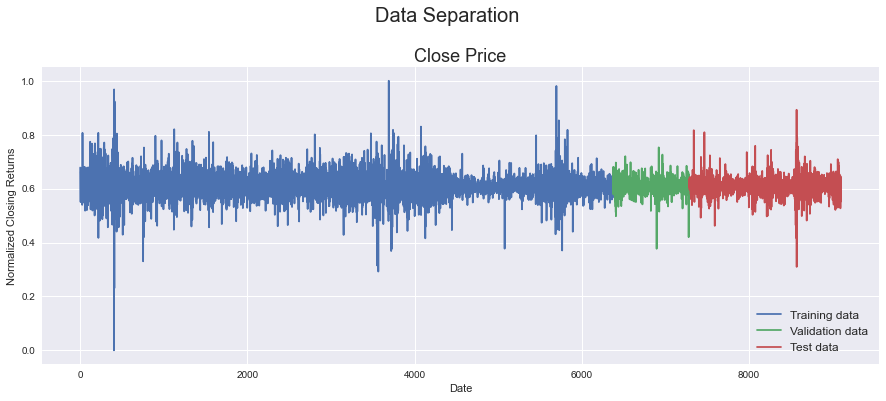

In [12]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train, label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val, label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test, label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

# ###############################################################################

# ax2 = fig.add_subplot(212)
# ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

# ax2.plot(np.arange(train_data.shape[0], 
#                    train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

# ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
#                    train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
# ax2.set_xlabel('Date')
# ax2.set_ylabel('Normalized Volume Changes')
# ax2.set_title("Volume", fontsize=18)
# ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [13]:
# Training data
shift_num = 15

X_train, y_train = [], []
for i in range(seq_len, len(train_data)-shift_num):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i+shift_num]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)


# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)-shift_num):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i+shift_num])
X_val, y_val = np.array(X_val), np.array(y_val)


# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)-shift_num):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i+shift_num])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (6230, 128, 1) (6230,)
Validation set shape (767, 128, 1) (767,)
Testing set shape (1676, 128, 1) (1676,)


In [14]:
train_data[:,0][seq_len]

0.6061834151448824

In [15]:
y_train

array([0.64742814, 0.66276479, 0.66908143, ..., 0.62822771, 0.62798991,
       0.62360579])

## Transformer

In [16]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

    #############################################################################


class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

            # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

    #############################################################################


class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config


def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, 1))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Model

In [18]:
model = create_model()
model.summary()

# callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
#                                               monitor='val_loss', 
#                                               save_best_only=True, verbose=1)

# model.fit(X_train, y_train, 
#                     batch_size=batch_size, 
#                     epochs=35, 
#                     callbacks=[callback],
#                     validation_data=(X_val, y_val))  
start = time.time()

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    validation_data=(X_val, y_val))  

stop = time.time()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 128, 2)       512         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 3)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 128, 3)      47890       ['concatenate[0][0]',        

195/195 [==============================] - 124s 635ms/step - loss: 0.0024 - mae: 0.0353 - mape: 97511.5703 - val_loss: 8.5894e-04 - val_mae: 0.0213 - val_mape: 3.5757
Epoch 27/35
195/195 [==============================] - 122s 627ms/step - loss: 0.0024 - mae: 0.0353 - mape: 96132.5938 - val_loss: 8.8897e-04 - val_mae: 0.0218 - val_mape: 3.6791
Epoch 28/35
195/195 [==============================] - 122s 628ms/step - loss: 0.0024 - mae: 0.0349 - mape: 98893.5781 - val_loss: 8.1792e-04 - val_mae: 0.0203 - val_mape: 3.3985
Epoch 29/35
195/195 [==============================] - 122s 627ms/step - loss: 0.0024 - mae: 0.0351 - mape: 94778.2578 - val_loss: 8.5371e-04 - val_mae: 0.0206 - val_mape: 3.3867
Epoch 30/35
195/195 [==============================] - 122s 627ms/step - loss: 0.0024 - mae: 0.0347 - mape: 96489.3906 - val_loss: 8.1423e-04 - val_mae: 0.0201 - val_mape: 3.3424
Epoch 31/35
195/195 [==============================] - 122s 627ms/step - loss: 0.0023 - mae: 0.0345 - mape: 94087.507

In [19]:
print(f"Training time: {stop - start}s")

Training time: 4310.113419294357s


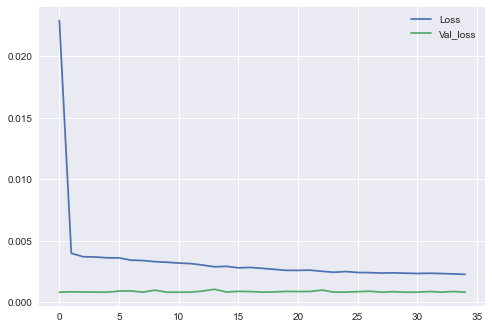

In [20]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val_loss")
plt.legend()
plt.show()

## Accuracy

In [21]:
def MSE(y_actual, y_predicted):
    mse = np.mean((y_actual - y_predicted)**2)
    return mse

def MAE(y_actual, y_predicted):
    mae = np.mean(abs(y_actual - y_predicted))
    return mae

def MAPE(y_actual, y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape

def RMSE(y_actual, y_predicted):
    rmse = np.sqrt(MSE(y_actual, y_predicted))
    return rmse

In [22]:
test_pred = model.predict(X_test)
mse = round(MSE(y_test, test_pred),5)
mae = round(MAE(y_test, test_pred),5)
mape = round(MAPE(y_test, test_pred),5)
rmse = round(RMSE(y_test, test_pred),5)
print("MSE: ",mse)
print("MAE: ",mae)
print("MAPE: ",mape)
print("RMSE: ",rmse)

MSE:  0.00118
MAE:  0.02308
MAPE:  3.83615
RMSE:  0.03436


## Store accuracy data

In [23]:
field_names = ["MSE", "MAE", "MAPE", "RMSE"]

In [24]:
new_row={'MSE':mse,'MAE': mae,'MAPE': mape,'RMSE':rmse}

In [25]:
file_route = 'Accuracy_15/Transformer.csv'

In [26]:
from csv import DictWriter

with open(file_route, 'a', encoding='UTF8') as f_object:
    
    dictwriter_object = DictWriter(f_object, fieldnames=field_names)

    dictwriter_object.writerow(new_row)
  
    f_object.close()

In [27]:
accuracy_Transformer = pd.read_csv(file_route)
accuracy_CNN_LSTM = pd.read_csv('Accuracy_15/CNN-LSTM.csv')
accuracy_LSTM = pd.read_csv('Accuracy_15/LSTM.csv')
accuracy_Transformer

,MSE,MAE,MAPE,RMSE
0,0.00119,0.02324,3.88638,0.03443
1,0.00119,0.02339,3.91854,0.03454
2,0.00118,0.02320,3.87767,0.03441
3,0.00118,0.02308,3.83615,0.03436


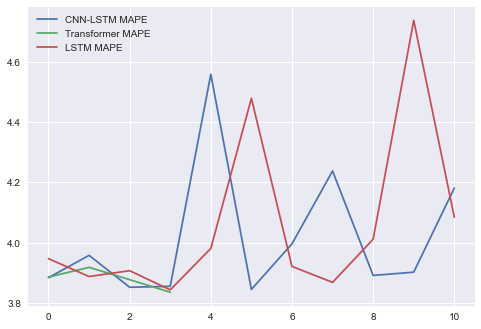

In [28]:
plt.plot(accuracy_CNN_LSTM["MAPE"], label = "CNN-LSTM MAPE")
plt.plot(accuracy_Transformer["MAPE"], label = "Transformer MAPE")
plt.plot(accuracy_LSTM["MAPE"], label = "LSTM MAPE")
plt.legend()
plt.show()

In [29]:
average = accuracy_Transformer.mean()
average

MSE     0.001185
MAE     0.023228
MAPE    3.879685
RMSE    0.034435
dtype: float64

## Other works

In [30]:
print(bbbbb)

NameError: name 'bbbbb' is not defined

In [ ]:
#################################################################################
'''Calculate predictions and metrics'''
#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [ ]:
def stock_predict(model, df_close, days):
    pred = model.predict(df_close)
    pred = scaler_1.inverse_transform(pred)
    return pred

In [ ]:
stock_predict(model,X_train,5)

In [ ]:
def stock_predict(model, df_close, scaler, days):
    # model = keras.models.load_model(model_path)

    train_size = int(len(df_close) * 0.8)
    close_test = df_close[train_size : len(df_close)]

    num_take = len(close_test) - 100
    x_input = close_test[num_take:].reshape(1, -1)
    temp_input = list(x_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    n_steps = 100
    i = 0
    while i < 60:

        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i = i + 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i = i + 1

    all_pred = scaler.inverse_transform(lst_output[:days])

    return all_pred

In [ ]:
df_new = df.reset_index()
df_close = np.array(df_new['Close']).reshape(-1,1)
stock_predict( model, df_close, scaler_1, 30)

In [ ]:
def predict_price(model, prices, predicting_days=1):
#     scaler_path = os.path.join(model_path, "scaler.pkl")
#     with open(scaler_path, "rb") as f:
#         scaler = pickle.load(f)
    scaled_prices = scaler_2.transform(prices)
    x_input = scaled_prices[-100:].T
    print(x_input)

#     model = keras.models.load_model(model_path)
    y_predict = model.predict(x_input)
    future = scaler_2.inverse_transform(y_predict).ravel()[0]
    daily_prediction = (1 + future) ** (1 / predicting_days) - 1

    prediction_series = [daily_prediction] * predicting_days
    return np.array(prediction_series)

In [ ]:
prediction = predict_price(model, prices, predicting_days=30)
prediction

In [ ]:
temp = (df['Close'] * (max_return - min_return))+ min_return
temp

In [ ]:
df['Close']

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
# model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
#                                    custom_objects={'Time2Vector': Time2Vector, 
#                                                    'SingleAttention': SingleAttention,
#                                                    'MultiAttention': MultiAttention,
#                                                    'TransformerEncoder': TransformerEncoder}

## Model metrics

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(model.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)